<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Challenge S7: Clasificación de sentimientos en tweets

## Objetivos:

El objetivo de este challenge es enfrentarse a un problema de clasificación de texto real: tweets descargados sobre las elecciones de EEUU en 2016, centrándonos en el preprocesamiento, que en este caso es crucial en un problema en el que el protagonista es el texto.

## Inicialización del entorno:

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from nltk.tokenize import TweetTokenizer,RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfTransformer


import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random

random.seed(1234)
pd.set_option('display.max_colwidth', 175) # incrementamos anchura de output

stopwords = stopwords.words('english')#Establecemos las stopwords de ingles por ser ese el idioma de los tweets
separadores = [',', '.', ';', ':', '?', '¿', '!', '¡','=','<','>',':(',':/','“','”','%','/','(',')',"…",'...',"..",'"','+','-',"'",'&','https://…','http','rt','�','*']
lista_palabras_tratadas=[]

In [2]:
df_train = pd.read_csv('./data/gop_tweets_train_psn.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8414 entries, 0 to 8413
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  8414 non-null   object
 1   text       8414 non-null   object
dtypes: object(2)
memory usage: 131.6+ KB


In [3]:
df_test = pd.read_csv('./data/gop_tweets_test_psn.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  2153 non-null   object
 1   text       2153 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB


Damos un vistazo a los textos que aparecen en el dataset.

In [4]:
df_train.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.
3,Positive,RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…


In [5]:
df_test.head()

,sentiment,text
0,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day I will rescind every illegal executive action taken by Barack Obama."" #GOPDebate @FoxNews"
1,Neutral,Going on #MSNBC Live with @ThomasARoberts around 2 PM ET. #GOPDebate
2,Positive,RT @WayneDupreeShow: Just woke up to tweet this out #GOPDebate \r\n\r\nBest line of the night via @GovMikeHuckabee http://t.co/6OV5hxHIcV
3,Negative,reason comment is funny 'in case you're ignorant' is the #gop #tcot are the reason the government isn't working for the people #gopdebate
4,Positive,"RT @ChuckNellis: Cruz has class &amp; truth, that gets my vote! #GOPDebate"


## ¿Qué número de tweets tenemos en cada dataset? ¿Cuántos de cada clase?

In [6]:
def infome_dataset_tweets (df_data, nombre):
    print('En el dataset de ', nombre,' tenemos:')
    print(' Un total de ',df_data.text.count(), ' tweets')
    print(' Si los contamos por tipología hay :')
    df_data_agrupado = df_data['sentiment'].value_counts()
    for i in range (df_data_agrupado.size):
        print('    Tweets del tipo ',df_data_agrupado.index[i],' existen ',int(df_data_agrupado.values[i]))
          
    print('\n')
    
infome_dataset_tweets(df_train,'trainning')
infome_dataset_tweets(df_test,'testing')
          

En el dataset de  trainning  tenemos:
 Un total de  8414  tweets
 Si los contamos por tipología hay :
    Tweets del tipo  Negative  existen  4872
    Tweets del tipo  Neutral  existen  2162
    Tweets del tipo  Positive  existen  1380


En el dataset de  testing  tenemos:
 Un total de  2153  tweets
 Si los contamos por tipología hay :
    Tweets del tipo  Negative  existen  1257
    Tweets del tipo  Neutral  existen  567
    Tweets del tipo  Positive  existen  329




## ¿Qué dificultades crees que presenta la diferencia entre la cantidad de clases?

* Al existir una clase más que el ejemplo del worksheet el coste para el clasificador será mayor.
* Por otro lado al estar los dataframes desbalanceados en el que el número de tweets negativos es mayor que el resto, del orden del doble de los neutros y del triple de los positivos puede influir, si aplicamos TF-IDF, a que se penalicen los terminos, con sentimiento negativo, que aparecen en bastante documentos negativos, con respecto a terminos frecuntes en la parte positiva y que aparecen poco o muy poco en la parte negativa. Creo que este es el caso en el que habría que tener cuidado a aplicar esta técnica de TF-IDF

## Clasificador de tweets

Vamos a construir nuestro propio clasificador sobre los tweets que hemos cargado. Los pasos que seguiremos serán:

* Preprocesar ambos conjuntos de tweets por separado.
* Entrenar clasificador con tweets de entrenamiento.
* Evaluar con tweets de test.

Primero, haremos una prueba para observar el rendimiento de nuestro clasificador sin ningún tipo de preprocesamiento.

In [7]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

Seguimos creando el clasificador y entrenando con el conjunto de entrenamiento de los tweets.

In [8]:
# creamos nuestro pipeline con vectorizador (bag of words) y clasificador
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearSVC(max_iter=1200))])

# entrenamos el clasificador
text_clf.fit(df_train['text'], df_train['sentiment'])

Pipeline(steps=[('vect', CountVectorizer()), ('clf', LinearSVC(max_iter=1200))])

Realizamos las predicciones con el conjunto de test y obtenemos la métrica de evaluación.

In [9]:
predicted = text_clf.predict(df_test['text'])
np.mean(predicted == df_test['sentiment'])

0.5973060845332094

Parece que hemos obtenido un resultado un poco peor... Ahora es cuando entra en juego el preprocesamiento del texto.

Ahora vamos a preprocesar el texto y construir un clasificador. Para ello, se ha creado esta función que nos automatiza el preprocesamiento. Deberás añadir el código que creas necesario y ejecutar la función para obtener el texto preprocesado. 

**Puedes definir todas las funciones de preprocesado que creas necesario, pero ten en cuenta varios detalles:**
* La funcion `preprocesar_texto` es llamada desde un `apply`. Esto significa que la función recibe un tweet y devuelve un tweet preprocesado con cada llamada. 
* Si el preprocesado es muy agresivo, un tweet puede quedarse fácilmente vacío, en esos casos el clasificador no podrá trabajar con él y escupirá la clase mayoritaria para ese tweet.
* Algunas técnicas no tienen sentido si se aplican después de otras dentro del pipeline. Por ejemplo, no tiene sentido aplicar POS después de realizar Stemming.
* Count Vectorizer necesita DOCUMENTOS y al trabajar con texto muchas veces es más sencillo hacer uso de TOKENS. Esto significa que tendremos que pasar cada tweet preprocesado en una cadena de texto. La función `" ".join(palabras)` que vimos en el worksheet es tu aliada.
* Si tu preprocesamiento va a ser intensivo, quizás es buena idea crear varias funciones que sean llamadas desde `preprocesar_texto`.

In [21]:
def tokeniza (texto):
    
    #Separamos palabras de cada tweet utilizando el tokenizer especial para tweets, TweetTokenizer
    #Eliminamos emojis ... o por lo menos lo intentamos
    texto=texto.encode('latin-1', 'ignore').decode('latin-1')
    
    palabras_tweets=[]
    palabras_tweets = TweetTokenizer().tokenize(texto)
    return palabras_tweets

def filtrar_palabras(lista_palabras):
    #Eliminamos stopwords, simbolos separadores y otros que puedan meter ruido, así como pasar a minúsculas
    # para que se considere la misma palabra aquella escrita en mayúsculas como la qe esta en minúsculas.
    
    lista_salida = []
    
    for palabra in lista_palabras:
        if palabra.lower() in stopwords: #Eliminamos stopwprds del idioma Inglés que se configuro al inicio.
            pass
        elif palabra.lower() in separadores: # Eliminamos simbolos de puntuación
            pass
        elif palabra.lower().startswith('#'):
             pass                       
        elif palabra.lower().startswith('@'):
             pass
        elif palabra.lower().startswith('htt'):
             pass 
        else:
            lista_salida.append(palabra.lower())

    return lista_salida

def get_wordnet_tag_pos_tag(POS_tag):
        
        #Mapeamos las etiqutas de POS a las etiquetas que se manejan para lematizar
        
        if POS_tag.startswith('J'):
            return wordnet.ADJ
        elif POS_tag.startswith('V'):
            return wordnet.VERB
        elif POS_tag.startswith('N'):
            return wordnet.NOUN
        elif POS_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
        
def lematiza (palabras, POS=None):
    
    lista_lematizada_salida=[]
    lemmatizer = WordNetLemmatizer()

    
    if POS: # Si palabras viene previamante de un proceso de Part Of Speech en el que ya vienen etiquetadas.

        for palabra, etiqueta_pos in palabras:
            etiqueta_wn = get_wordnet_tag_pos_tag(etiqueta_pos)
            if etiqueta_wn is None:# En caso de no encontar la etiqueta lematizamos sin ella.
                lista_lematizada_salida.append(lemmatizer.lemmatize(palabra))
            else:
                lista_lematizada_salida.append(lemmatizer.lemmatize(palabra, pos=etiqueta_wn))
                
    else: # En caso contrario nos limitamos a lematizar y encontrar la raíz correcta de la palabra.
         lista_lematizada_salida=([lemmatizer.lemmatize(palabra) for palabra in lista_palabras])
    
    return lista_lematizada_salida



def POS (lista_palabras):
   # Sometemos la lista de palabras a un Part Of Speech para etiquetarlas.
    return pos_tag(lista_palabras)


def preprocesar_texto(texto):
    """ Función para preprocesamiento de texto.
    Args:
        texto: cadena de texto a preprocesar.
    Returns:
        mismo texto preprocesado.
    """
    texto_filtrado = ""
    # AQUÍ TU CÓDIGO
    lista_palabras=[]

    lista_palabras = tokeniza(texto)
    lista_palabras = filtrar_palabras(lista_palabras)
    lista_palabras = POS(lista_palabras)
    lista_palabras = lematiza(lista_palabras,POS=True)
    lista_palabras = filtrar_palabras(lista_palabras)
    
    
     # Guardamos en esta lista todas las palabras resultantes del proceso de preprocesamiento
    # para posteriormente ver frecuencias. worldcloud, gráficas, ...etc.
    lista_palabras_tratadas.extend(lista_palabras)
    
    texto_filtrado=" ".join(lista_palabras)

    return texto_filtrado

In [25]:
#Probamos en un tweet como funciona el proceso de preprocesamiento.
print('Tweet Original : ',df_train['text'][77],'\n')
print('Tweet preprocesado : ',preprocesar_texto(df_train['text'][77]))

Tweet Original :  RT @JRehling: #GOPDebate Donald Trump says that he doesn't have time for political correctness. How does calling women "fat pigs" save him … 

Tweet preprocesado :  donald trump say time political correctness call woman fat pig save


Aplicamos el preprocesamiento a los dos conjuntos de tweets y lo guardamos en la columna `prep`.

In [12]:
#print(lista_palabras_tratadas)
df_train['prep'] = df_train['text'].apply(preprocesar_texto)
df_test['prep'] = df_test['text'].apply(preprocesar_texto)
#print(lista_palabras_tratadas)

Antes de reentrenar nuestro clasificador, siempre es recomendable dar un vistazo al resultado del texto dentro del dataframe. También observar frecuencia de palabras o simplemente generar un WordCloud.

In [13]:
# AQUÍ TU CÓDIGO

#Función que nos calcula las n palabras más frecuentes de una lista de palabras y posteriormente lo grafica 
# y muestra wordcloud
def calcula_frecuencias_palabras(palabras, n):

    lista_palabras_mas_frecuentes = []
    fdist = FreqDist(palabras)
    lista_palabras_mas_frecuentes = fdist.most_common()
   
    # Generamos un dataframe con las n palabras más frecuentes.
    df_palabras_mas_frecuentes = pd.DataFrame(
        lista_palabras_mas_frecuentes).rename(columns={0: "word", 1: "times"}).sort_values(
        by="times", ascending=False)
    df_palabras_mas_frecuentes_p = df_palabras_mas_frecuentes.sort_values(
        by="times", ascending=False)[:n]
    
    # Creamos la gráfica
    plt.rcParams.update({'font.size': 16})
    
    fig, axs = plt.subplots(1,2,tight_layout=True, figsize=(26, 10))
    # Creamos un diagrama de barras
    axs[0].barh(df_palabras_mas_frecuentes_p['word'],
             df_palabras_mas_frecuentes_p['times'], color='orange')

    # Eliminamos la cuadrícula
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    # axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_visible(False)

    # Añadimos líneas horizontales blancas que partan nuestra figura.
    axs[0].grid(True, axis='x')
    axs[0].set_ylabel('Palabras', fontdict={'size': 16})
    axs[0].set_xlabel('Número de aparaciones')

    palabras_juntas = ' '.join(df_palabras_mas_frecuentes_p.word)
    wordcloud = WordCloud(width = 750, height = 500, relative_scaling = 0.5).generate(palabras_juntas)
#     axs[1].figure(figsize=(15,8))
    axs[1].imshow(wordcloud)
    axs[1].axis("off")
    #plt.show()
    
     # Etiquetamos la figura.
    titulo='Top '+str(n)+' de Palabras más frecuentes'
    fig.suptitle(titulo,
                 fontdict={'size': 26})

    
    return 

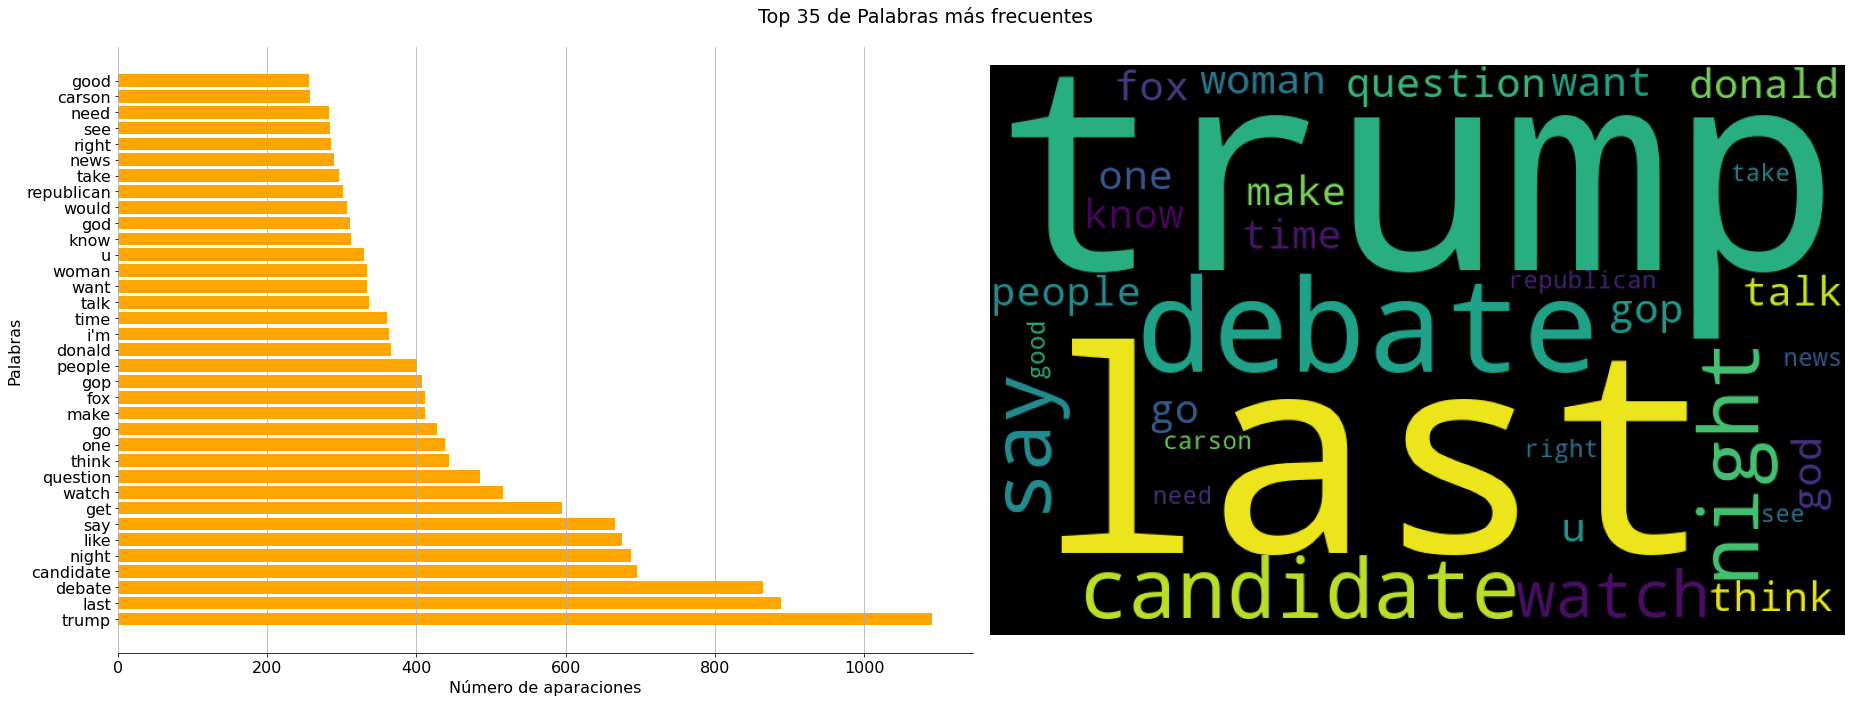

In [19]:
#Vamos a mostrar las 35 palabras más frecuntes
calcula_frecuencias_palabras(lista_palabras_tratadas,35)

Ahora sí, vamos a reentrenar el clasificador y evaluar de nuevo. Puedes hacer uso del mismo pipeline anterior o simplemente crear uno nuevo con más etapas.

In [15]:
# Nuevo pipeline si es que es necesario. Por defecto usamos el anterior. Recuerda RE-ENTRENAR en cualquier caso!
# Creamos un nuevo pipeline en el que le vamos a meter una etapa nueva para aplicar TF-IDF
# La bolsa de palabras la configuramos para que tenga en cuenta n-gramas, en este caso de 2.
new_clf = Pipeline([('vect', CountVectorizer(tokenizer = TweetTokenizer().tokenize,ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer(use_idf = True, smooth_idf=True)),
                     ('clf', LinearSVC())])


In [16]:
# Predicción haciendo uso del pipeline correspondiente. ¡Recuerda cambiarlo si has creado uno nuevo!
# entrenamos el nuevo clasificador
new_clf.fit(df_train['prep'], df_train['sentiment'])
#hacemos predicción
predicted = new_clf.predict(df_test['prep'])
np.mean(predicted == df_test['sentiment'])

0.6409660938225732

* ¿Qué opinas de los resultados obtenidos?
<br>

    * Se ha obtenido una mejora en el Accuracy al aplicar preprocesado e incluir una nueva etapa la de TF-IDF.
    * Sin prepocesao y con dos fases se obtuvo un Accuracy de 0.5973060845332094 y con el nuevo un Accuracy de **0.6409660938225732**, por lo que ahora se es capaz de determinar el sentimiento de una palabra en más de un **64%** de los casos
<br>

* ¿Por qué crees que ha sucedido esto?
<br>

    * Creo que ayudado el preprocesado por que al reducir "ruido", eliminando stopwords, signos y "compactando" la frecuencia de las palabras al ponerlas en minúsculas y lematizando, y por otra parte la aplicación de TF-LDF ha ponderado la importancia de los terminos más importantes y significativos. Todo esto en conjunto creo que afina la predicción del algoritmo de clasificación utilizado (LinearSVC)

¿Podrías explicarme con tus palabras en qué consiste Tf-Idf?

* TD-LDF es el algoritmo que detecta la palabras más relevantes dentro de un corpus de documentos.
    * Por un lado, la parte **TF** premia la aparación de esa palabra dentro del documento, sobre el resto de palabras que componen el documento, llegando a un valor máximo de 1, si todos las palabras de ese documento fueran la palabra que analizamos. Y por otra parte esta **LDF** en el que se pondera la aparición de esa palabra en los documentos del corpus, a mayor número de apariciones mayor es la penalización. Esto sirve por ejemplo para detectar stopwords que no aportan significación alguna. O palabras muy comunes y muy extendidas en los documentos que no aportan inforrmación relevante. **El resultado final es el producto del coreficiente obtenido en TF * el coeficiente obtenido en LDF.**
    
¿Cual es la idea intuitiva de aplicar esta transformación a la matriz?

* La idea o lo que entiendo que es la intención es la de quitar palabras irrelevantes que no aportan información en cuanto al sentiemiento que podría tener el texto o textos en el que se incluyen, en este caso los tweets, por muchas apariciones que pudieran tener, y quedarse o significar las mas relevantes en cuanto a determinar el sentimiento. Así se obtienen unos mejores y "más afinados" dataset de entreno y de test para que los algoritmos clasificadores fucionen de forma más precisa o con mayor porcentaje de acierto.